### Import lib

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy
import dask

In [49]:
train = pd.read_csv('taxi_fare/train.csv')
test = pd.read_csv('taxi_fare/test.csv')
submission = pd.read_csv('taxi_fare/submission.csv')

### Data Visualisation

In [5]:
# 1
train.head()

,trip_duration,distance_traveled,num_of_passengers,fare,tip,miscellaneous_fees,total_fare,surge_applied
0,748.0,2.75,1.0,75.00,24,6.300,105.300,0
1,1187.0,3.43,1.0,105.00,24,13.200,142.200,0
2,730.0,3.12,1.0,71.25,0,26.625,97.875,1
3,671.0,5.63,3.0,90.00,0,9.750,99.750,0
4,329.0,2.09,1.0,45.00,12,13.200,70.200,0


In [6]:
train.dtypes

trip_duration         float64
distance_traveled     float64
num_of_passengers     float64
fare                  float64
tip                     int64
miscellaneous_fees    float64
total_fare            float64
surge_applied           int64
dtype: object

In [7]:
test.head()

,trip_duration,distance_traveled,num_of_passengers,fare,tip,miscellaneous_fees,total_fare,surge_applied
0,1076.0,4.18,1.0,0,0,13.500,0,0
1,429.0,1.48,4.0,0,0,13.500,0,0
2,856.0,4.15,1.0,0,24,6.000,0,0
3,622.0,3.22,1.0,0,15,5.625,0,0
4,507.0,3.98,1.0,0,0,2.250,0,0


In [8]:
test.dtypes

trip_duration         float64
distance_traveled     float64
num_of_passengers     float64
fare                    int64
tip                     int64
miscellaneous_fees    float64
total_fare              int64
surge_applied           int64
dtype: object

In [10]:
test['total_fare'].value_counts(), 

(0    89861
 Name: total_fare, dtype: int64,)

In [11]:
test['surge_applied'].value_counts(), 


(0    64495
 1    25366
 Name: surge_applied, dtype: int64,)

In [12]:
submission.head()

,total_fare
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


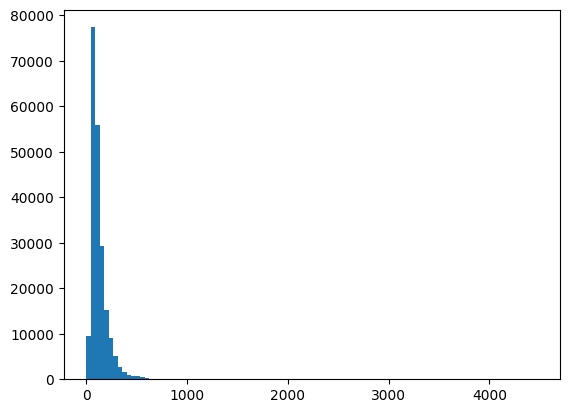

In [13]:
# 2
# Class imbalance implies classification problem, surge has 1,0 values in both train and test, submission
# indicates total_fare is the label which assumes numerical values

# looking at distribution of total_fare instead 
plt.hist(train['total_fare'], bins=100)
plt.show()

In [14]:
# imples a very high left skew
quantiles = np.quantile(train['total_fare'], np.array([0.00, 0.25, 0.50, 0.75, 1.00]))
quantiles

array([   0.  ,   70.2 ,  101.7 ,  152.25, 4472.25])

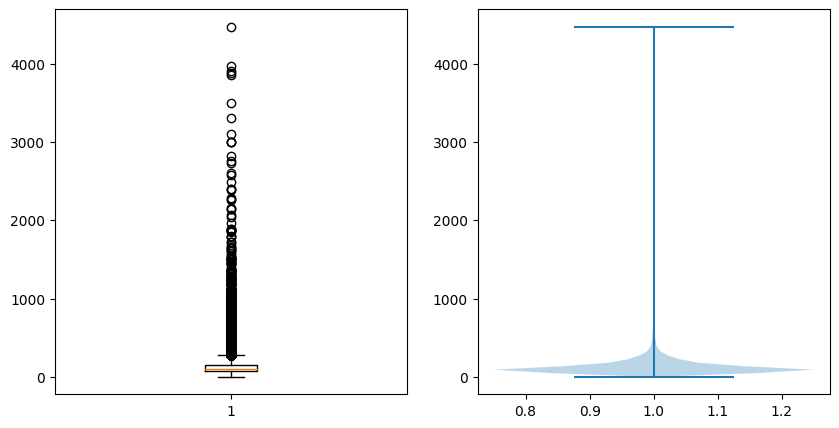

In [15]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.boxplot(train['total_fare'])

plt.subplot(1, 2, 2)
plt.violinplot(train['total_fare'])

plt.show()

In [16]:
# 3
for col in train.columns:
    if len(train[col].unique()) > 2 :
        print({col: np.quantile(train[col], np.array([0.00, 0.25, 0.50, 0.75, 1.00]))})

{'trip_duration': array([    0.,   446.,   707.,  1098., 86387.])}
{'distance_traveled': array([2.000000e-02, 1.950000e+00, 3.200000e+00, 5.730000e+00,
       5.728391e+04])}
{'num_of_passengers': array([0., 1., 1., 1., 9.])}
{'fare': array([   0.  ,   52.5 ,   75.  ,  116.25, 4466.25])}
{'tip': array([   0.,    0.,    9.,   20., 2500.])}
{'miscellaneous_fees': array([ -0.5 ,   6.  ,   9.75,  26.45, 435.  ])}
{'total_fare': array([   0.  ,   70.2 ,  101.7 ,  152.25, 4472.25])}


In [17]:
for col in train.columns:
    if len(train[col].unique()) > 2 :
        print({col: len(train[col].unique())})

{'trip_duration': 5907}
{'distance_traveled': 2463}
{'num_of_passengers': 10}
{'fare': 631}
{'tip': 262}
{'miscellaneous_fees': 1674}
{'total_fare': 3742}


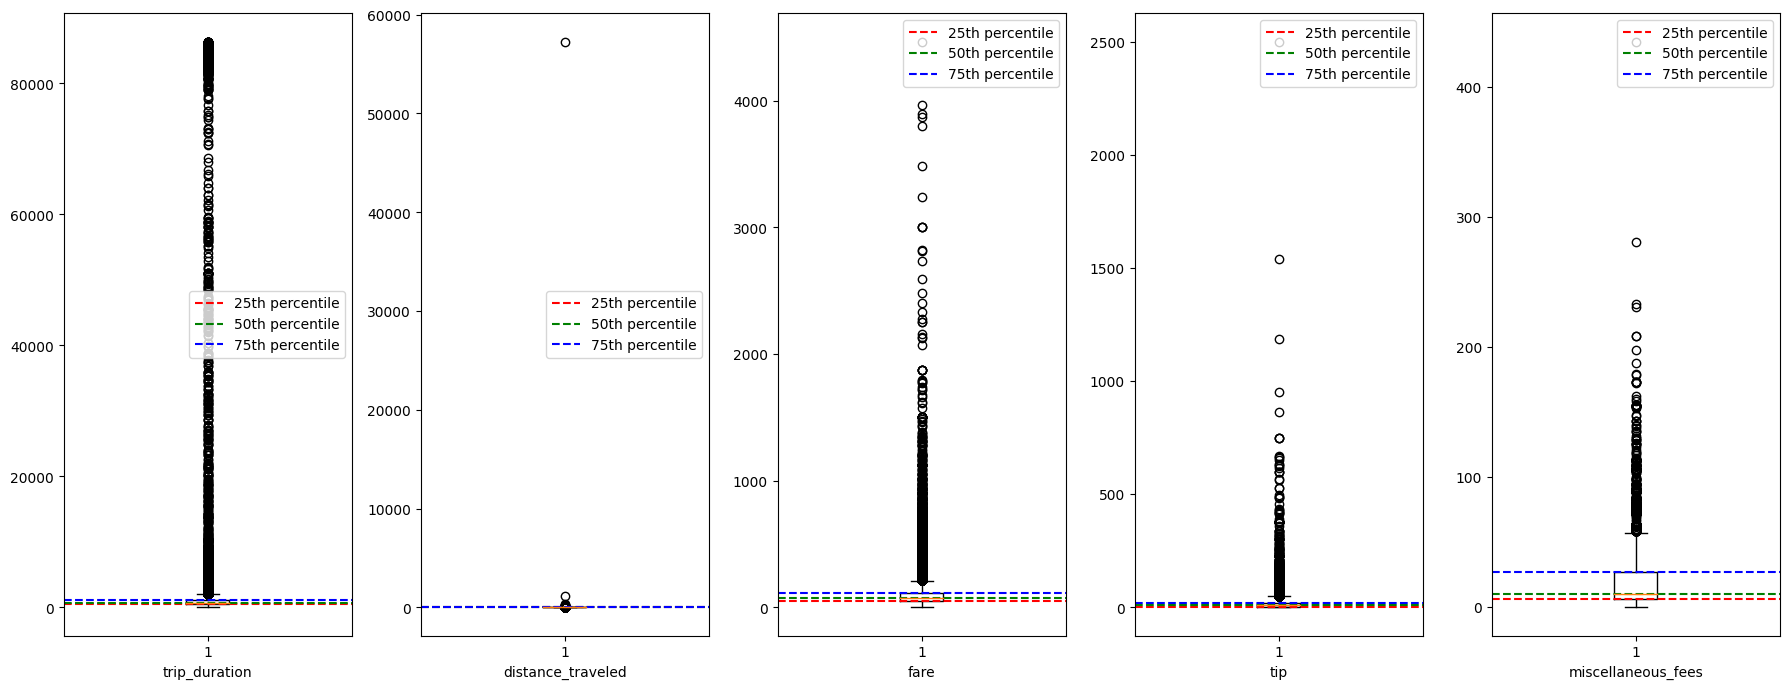

In [18]:
num_cols = ['trip_duration', 'distance_traveled', 'fare', 'tip', 'miscellaneous_fees']
quantiles = [25, 50, 75]

plt.figure(figsize=(18, 7))

for i, column in enumerate(num_cols, start=1):
    plt.subplot(1, 5, i)
    plt.boxplot(train[column])
    plt.xlabel(column)
    column_quantiles = np.percentile(train[column], quantiles)
    colors = ['r', 'g', 'b']
    linestyles = ['--', '--', '--']
    labels = [f'{q}th percentile' for q in quantiles]
    for quantile, color, linestyle, label in zip(column_quantiles, colors, linestyles, labels):
        plt.axhline(quantile, color=color, linestyle=linestyle, label=label)
    plt.legend()

plt.tight_layout()
plt.show()


0    150855
1     58818
Name: surge_applied, dtype: int64


1.0    179229
2.0     17896
5.0      4713
6.0      3382
3.0      2757
4.0       908
0.0       753
8.0        25
9.0         8
7.0         2
Name: num_of_passengers, dtype: int64




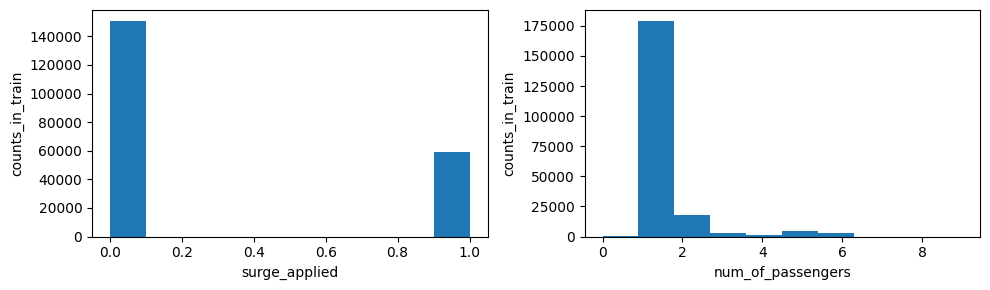

In [19]:
cat_col = ['surge_applied', 'num_of_passengers']
for col in cat_col:
    print(train[col].value_counts())
    print('\n')

plt.figure(figsize=(10, 3))
plt.subplot(1,2,1)
plt.hist(train['surge_applied'])
plt.xlabel('surge_applied')
plt.ylabel('counts_in_train')

plt.subplot(1,2,2)
plt.hist(train['num_of_passengers'])
plt.xlabel('num_of_passengers')
plt.ylabel('counts_in_train')

plt.tight_layout()
plt.show()

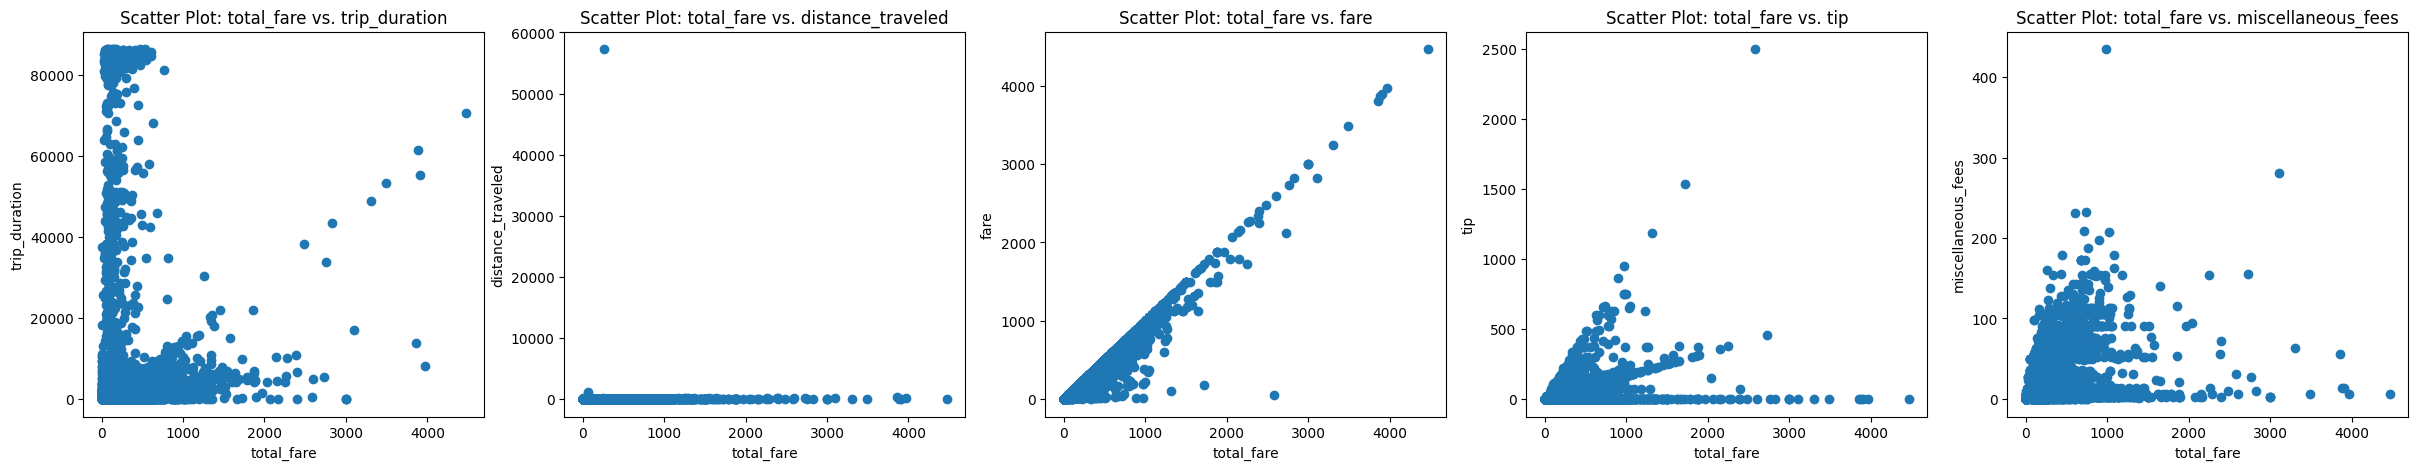

In [20]:
# 3, 5 

# realationship of features with label
# numerical
plt.figure(figsize=(30,5))
for i, col in enumerate(num_cols, start=1):
    plt.subplot(1, 5, i)
    plt.scatter(train['total_fare'], train[col])
    plt.ylabel(col)
    plt.xlabel('total_fare')
    plt.title(f'Scatter Plot: total_fare vs. {col}')
plt.show()
    

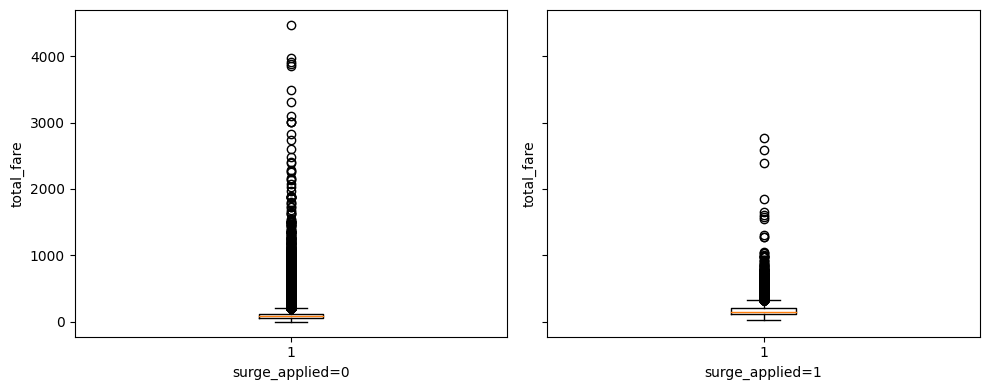

In [21]:
# categorical
col_1 = cat_col[0]
categories_1 = train[col_1].unique()

# Create subplots using plt.subplots
fig, axes = plt.subplots(1, len(categories_1), figsize=(10, 4), sharey=True)

# Iterate over each category of col_1
for i, cat_1 in enumerate(categories_1):
    # Select data points with matching category
    data = train[train[col_1] == cat_1]
    
    # Plot boxplot of numerical label
    axes[i].boxplot(data['total_fare'])
    axes[i].set_xlabel(f'{col_1}={cat_1}')
    axes[i].set_ylabel('total_fare')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


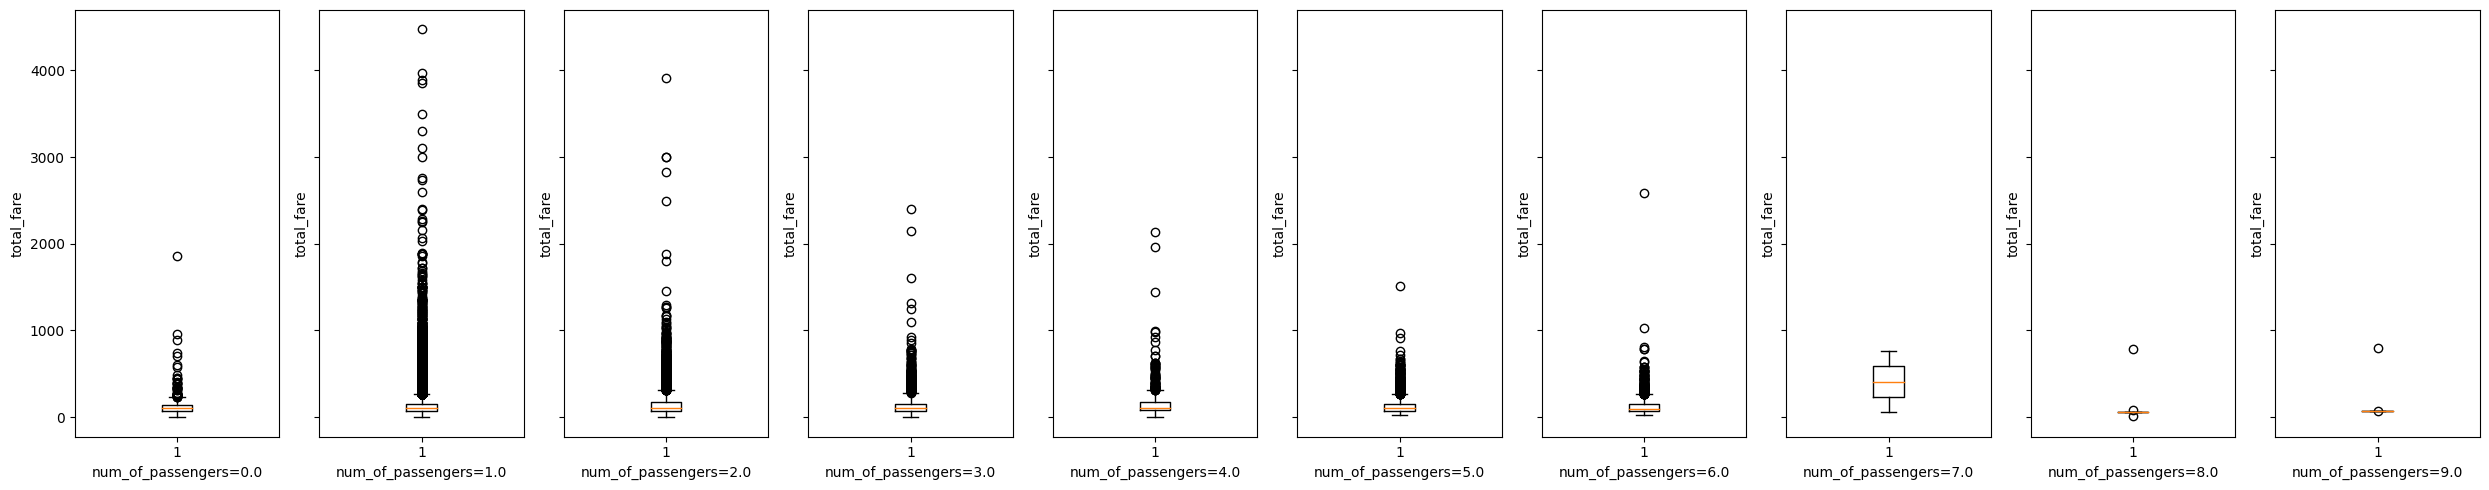

In [22]:
col_1 = cat_col[1]
categories_1 = train[col_1].unique()

# Create subplots using plt.subplots
fig, axes = plt.subplots(1, len(categories_1), figsize=(25, 5), sharey=True)

# Iterate over each category of col_1
for i, cat_1 in enumerate(sorted(categories_1)):
    # Select data points with matching category
    data = train[train[col_1] == cat_1]
    
    # Plot boxplot of numerical label
    axes[i].boxplot(data['total_fare'])
    axes[i].set_xlabel(f'{col_1}={cat_1}')
    axes[i].set_ylabel('total_fare')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


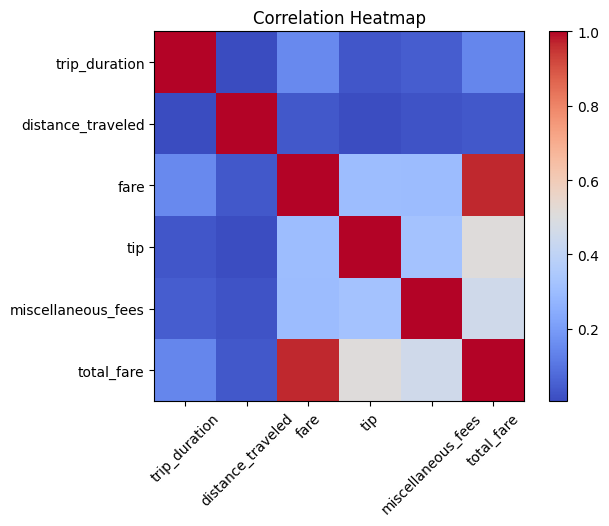

In [23]:
# 4 
# correlation check
col_list = num_cols + ['total_fare']
correlation_matrix = train[col_list].corr()

fig, ax = plt.subplots()
heatmap = ax.imshow(correlation_matrix, cmap='coolwarm')

ax.set_xticks(np.arange(len(col_list)))
ax.set_yticks(np.arange(len(col_list)))
ax.set_xticklabels(col_list)
ax.set_yticklabels(col_list)

plt.xticks(rotation=45)
cbar = plt.colorbar(heatmap)
plt.title('Correlation Heatmap')
plt.show()


From here it can be seen that fare and total_fare are highly corrrlated (0.967). rest features dont show high correlation
with each other or label, tip comes closest. Correlation among features is less than 0.8 in all cases, we dont need to drop anything.

In [100]:
correlation_matrix

,trip_duration,distance_traveled,fare,tip,miscellaneous_fees,total_fare
trip_duration,1.000000,0.005774,0.150331,0.029132,0.046432,0.142159
distance_traveled,0.005774,1.000000,0.035934,0.013487,0.021734,0.036677
fare,0.150331,0.035934,1.000000,0.302044,0.299321,0.966748
tip,0.029132,0.013487,0.302044,1.000000,0.320919,0.508639
miscellaneous_fees,0.046432,0.021734,0.299321,0.320919,1.000000,0.452568
total_fare,0.142159,0.036677,0.966748,0.508639,0.452568,1.000000


### Data Pre-processing

In [39]:
#1 Check presence of null value
train.isna().sum()
test.isna().sum()


trip_duration         0
distance_traveled     0
num_of_passengers     0
fare                  0
tip                   0
miscellaneous_fees    0
total_fare            0
surge_applied         0
dtype: int64

#2 Handle skewness As we data is left skewed for all the variables , we can apply log transformation or BoxCox transformation 
to handle skweness , we'll use BoxCox here as it performs better than Natural Log transformation and works best when we have both positive and negative values as we can see in miscellaneous_fees 

In [ ]:
d_train=train.copy()

In [50]:
# Log transformation
train['trip_duration'] = np.log1p(train['trip_duration'])
train['distance_traveled'] = np.log1p(train['distance_traveled'])
train['fare'] = np.log1p(train['fare'])
train['tip'] = np.log1p(train['tip'])
train['miscellaneous_fees'] = np.log1p(train['miscellaneous_fees'])
train['total_fare'] = np.log1p(train['total_fare'])

# Power transformation (Example: Square Root)
train['num_of_passengers'] = np.log1p(train['num_of_passengers'])


In [51]:
train.head()

,trip_duration,distance_traveled,num_of_passengers,fare,tip,miscellaneous_fees,total_fare,surge_applied
0,6.618739,1.321756,0.693147,4.330733,3.218876,1.987874,4.666265,0
1,7.080026,1.488400,0.693147,4.663439,3.218876,2.653242,4.964242,0
2,6.594413,1.415853,0.693147,4.280132,0.000000,3.318721,4.593856,1
3,6.510258,1.891605,1.386294,4.510860,0.000000,2.374906,4.612642,0
4,5.799093,1.128171,0.693147,3.828641,2.564949,2.653242,4.265493,0


In [52]:
# Step 2: Handle outliers (example: replace outliers with median)
for feature in train.columns:
    if feature not in ['total_fare']:
        Q1 = train[feature].quantile(0.25)
        Q3 = train[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        train[feature] = np.where(train[feature] < lower_bound, train[feature].median(), train[feature])
        train[feature] = np.where(train[feature] > upper_bound, train[feature].median(), train[feature])

In [53]:
train.head()

,trip_duration,distance_traveled,num_of_passengers,fare,tip,miscellaneous_fees,total_fare,surge_applied
0,6.618739,1.321756,0.693147,4.330733,3.218876,1.987874,4.666265,0.0
1,7.080026,1.488400,0.693147,4.663439,3.218876,2.653242,4.964242,0.0
2,6.594413,1.415853,0.693147,4.280132,0.000000,3.318721,4.593856,1.0
3,6.510258,1.891605,0.693147,4.510860,0.000000,2.374906,4.612642,0.0
4,5.799093,1.128171,0.693147,3.828641,2.564949,2.653242,4.265493,0.0


#3 Handle class Imbalance

In [54]:
from imblearn.over_sampling import SMOTE

X = train.drop('surge_applied', axis=1)  # Exclude the "fare" column from the feature set
y = train['surge_applied']

smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)

In [55]:
# Create a dataframe from the resampled arrays
train = pd.DataFrame(X_resampled, columns=X.columns)
train['surge_applied'] = y_resampled

train.head()

,trip_duration,distance_traveled,num_of_passengers,fare,tip,miscellaneous_fees,total_fare,surge_applied
0,6.618739,1.321756,0.693147,4.330733,3.218876,1.987874,4.666265,0.0
1,7.080026,1.488400,0.693147,4.663439,3.218876,2.653242,4.964242,0.0
2,6.594413,1.415853,0.693147,4.280132,0.000000,3.318721,4.593856,1.0
3,6.510258,1.891605,0.693147,4.510860,0.000000,2.374906,4.612642,0.0
4,5.799093,1.128171,0.693147,3.828641,2.564949,2.653242,4.265493,0.0


Normalization We can use Min-Max scaling method, also known as feature scaling. It scales the values in each feature to a fixed range, typically between 0 and 1. This normalization technique preserves the relative relationships between the data points

In [56]:
X=train.drop('total_fare', axis=1)
y=train['total_fare']

In [57]:
X.head()

,trip_duration,distance_traveled,num_of_passengers,fare,tip,miscellaneous_fees,surge_applied
0,6.618739,1.321756,0.693147,4.330733,3.218876,1.987874,0.0
1,7.080026,1.488400,0.693147,4.663439,3.218876,2.653242,0.0
2,6.594413,1.415853,0.693147,4.280132,0.000000,3.318721,1.0
3,6.510258,1.891605,0.693147,4.510860,0.000000,2.374906,0.0
4,5.799093,1.128171,0.693147,3.828641,2.564949,2.653242,0.0


In [58]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the training data
train_normalized = scaler.fit_transform(X)

# Convert the normalized data back to a dataframe
train_normalized = pd.DataFrame(train_normalized, columns=X.columns)

# Check the normalized dataframe
print(train_normalized.head())


   trip_duration  distance_traveled  num_of_passengers      fare       tip  \
0       0.518416           0.416769                0.0  0.455824  0.438567   
1       0.646630           0.470114                0.0  0.568363  0.438567   
2       0.511655           0.446891                0.0  0.438708  0.000000   
3       0.488264           0.599184                0.0  0.516752  0.000000   
4       0.290596           0.354801                0.0  0.285990  0.349470   

   miscellaneous_fees  surge_applied  
0            0.371932            0.0  
1            0.496423            0.0  
2            0.620934            1.0  
3            0.444346            0.0  
4            0.496423            0.0  


In [67]:
train_normalized=train_normalized.drop('fare', axis=1)

In [68]:
X_scaled=train_normalized
y=y

In [71]:
from sklearn.ensemble import RandomForestRegressor

# Assuming X_scaled and y_resampled are prepared and scaled
rf = RandomForestRegressor()
rf.fit(X_scaled, y)

importances = rf.feature_importances_


In [72]:
importances

array([1.37706719e-01, 6.63707532e-01, 0.00000000e+00, 1.27317457e-01,
       7.08693721e-02, 3.98919817e-04])

              Feature  Importance
1   distance_traveled    0.663708
0       trip_duration    0.137707
3                 tip    0.127317
4  miscellaneous_fees    0.070869
5       surge_applied    0.000399
2   num_of_passengers    0.000000


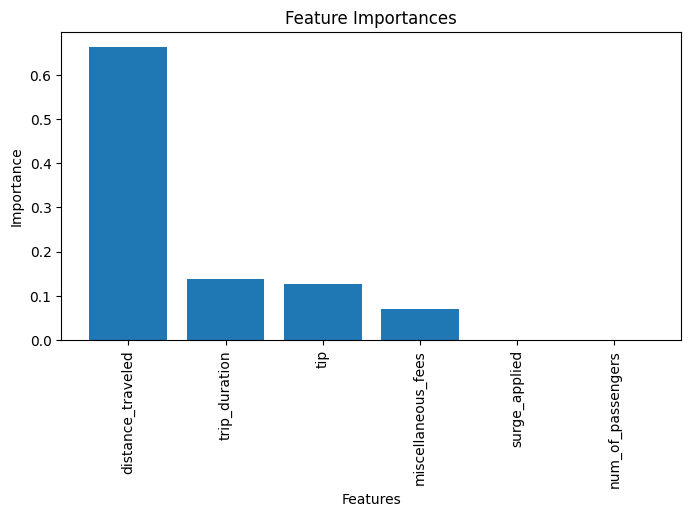

In [73]:
# Create a DataFrame to store feature importances
feature_importances = pd.DataFrame({'Feature': X_scaled.columns, 'Importance': importances})

# Sort the features by importance in descending order
feature_importances = feature_importances.sort_values('Importance', ascending=False)

# Print the feature importances
print(feature_importances)

# Plot the feature importances
plt.figure(figsize=(8, 4))
plt.bar(feature_importances['Feature'], feature_importances['Importance'])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()

In [74]:
test['total_fare'].value_counts()

0    89861
Name: total_fare, dtype: int64

In [76]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


In [77]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
model = lgb.LGBMRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


Mean Squared Error: 0.017497057912076758


In [ ]:

y_pred = np.exp(y_pred)

In [78]:
mse = mean_squared_error(np.exp(y_test), np.exp(y_pred))
print("Mean Squared Error:", mse)


Mean Squared Error: 1841.6135106874708


In [79]:
import numpy as np

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Assuming y_true contains the true target values and y_pred contains the predicted target values
mape_value = mape(np.exp(y_test), np.exp(y_pred))

# Print the MAPE value
print("MAPE:", mape_value)


MAPE: 5.119128863331221


Evaluate model with out of sample data

In [80]:
testoos=test.copy()

In [81]:
# Log transformation
testoos['trip_duration'] = np.log1p(testoos['trip_duration'])
testoos['distance_traveled'] = np.log1p(testoos['distance_traveled'])
testoos['fare'] = np.log1p(testoos['fare'])
testoos['tip'] = np.log1p(testoos['tip'])
testoos['miscellaneous_fees'] = np.log1p(testoos['miscellaneous_fees'])
testoos['total_fare'] = np.log1p(testoos['total_fare'])

# Power transformation (Example: Square Root)
testoos['num_of_passengers'] = np.log1p(testoos['num_of_passengers'])


In [82]:
testoos.head()

,trip_duration,distance_traveled,num_of_passengers,fare,tip,miscellaneous_fees,total_fare,surge_applied
0,6.981935,1.644805,0.693147,0.0,0.000000,2.674149,0.0,0
1,6.063785,0.908259,1.609438,0.0,0.000000,2.674149,0.0,0
2,6.753438,1.638997,0.693147,0.0,3.218876,1.945910,0.0,0
3,6.434547,1.439835,0.693147,0.0,2.772589,1.890850,0.0,0
4,6.230481,1.605430,0.693147,0.0,0.000000,1.178655,0.0,0


In [83]:
test_feat=[feat for feat in testoos.columns if feat not in ['fare','total_fare']]

In [84]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler = MinMaxScaler()
X=testoos[test_feat]
# Fit and transform the training data
test_normalized = scaler.fit_transform(X)

# Convert the normalized data back to a dataframe
test_normalized = pd.DataFrame(test_normalized, columns=X.columns)

# Check the normalized dataframe
test_normalized.head()


,trip_duration,distance_traveled,num_of_passengers,tip,miscellaneous_fees,surge_applied
0,0.614245,0.136920,0.30103,0.000000,0.497920,0.0
1,0.533469,0.074860,0.69897,0.000000,0.497920,0.0
2,0.594143,0.136431,0.30103,0.489247,0.390236,0.0
3,0.566088,0.119650,0.30103,0.421414,0.382094,0.0
4,0.548135,0.133602,0.30103,0.000000,0.276782,0.0


In [85]:
y_pred = model.predict(test_normalized)
y_pred=np.exp(y_pred)

In [86]:
y_pred

array([ 88.03405269,  64.75748569, 121.49436334, ..., 109.03604938,
       146.26701219, 103.32053941])